In [106]:
import os
import pandas as pd
import numpy as np
import quantstats as qs
from typing import Dict
import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [107]:
########## Parameters class 
####Core principals to be decided once and not changed through out the strategy

# 15 mins ORB
# enter a spread on either side which is tested first


class Params():
    def __init__(self) -> None:
    # Non changeable parameters
        self.Period = "15 mins"
        self.strike_chng = 5
        self.lot_size = 100
        self.ref_atm = 0
        self.ref_time = None
        self.period_high = 0
        self.period_low = 0 
        self.start_ORB_time = dt.time(9,31)
        self.end_ORB_time = dt.time(10)
        self.entry_time = dt.time(9,31,10)
        self.max_lots = 0
        self.net_credit = 0
        self.sid = 1
        self.enter_spread = False
        self.enter_condor = False
        self.base_straddle = 0
        self.ref_call_sell = 0
        self.ref_put_sell = 0
        self.ref_call_buy = 0
        self.ref_put_buy = 0
        self.breakevens = []
        


    # Changeable parameters
        self.strikes_away = 15
        self.strategy_stoploss = 0
        self.square_off_time = dt.time(15)
        self.condor_pnl = 0
        self.spread_pnl = 0
        self.realised_pnl = 0
        self.unrealised_pnl = 0
        self.ORB_range = 0
        self.threshold = 0
        self.abort_strategy = 0
        self.peak_spread_pnl = 0
        self.peak_condor_pnl = 0
        self.side = ""
        self.spread_entry_tm = None 
        self.condor_callspread_pnl = 0
        self.condor_putspread_pnl = 0 

        


class Single_leg():
    def __init__(self):
        self.strike = 0
        self.bs = 0
        self.status = 0
        self.open_px = 0
        self.close_px = 0
        self.open_time = 0
        self.close_time = 0
        self.lots = 0
        self.m2m = 0


class Condor():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.call_sell = Single_leg()
        self.put_sell = Single_leg()
        self.call_buy = Single_leg()
        self.put_buy = Single_leg()
        self.condor_status = 0
        self.net_credit = 0
        self.max_loss = 0
        self.max_profit = 0

class Vertical_spread():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.opt_type = ""
        self.sell_leg = Single_leg()
        self.buy_leg = Single_leg() 
        self.spread_status = 0
        self.max_loss = 0
        self.max_profit = 0
        self.net_credit = 0
        

class Position():
    def __init__(self) -> None:
        self.sid = 0
        self.open_time = None
        self.condor = Condor()
        self.spread = Vertical_spread()


        # Condor params
        
class OHLC():
    def __init__(self):
        self.df = None
        self.timeframe = 0

    def making_ohlc(self,df,timeframe):
        self.df = df
        self.timeframe = timeframe

        
        self.df = self.df.resample(timeframe,
                                origin = "start",
                                offset = "0min").agg({"undLtp": ["first","max","min","last"]})
        self.df.columns = ["Open","High","Low","Close"]

        return self.df
        


In [108]:
#### Model Functions ###
def check_orb_breakout(ohlc_df,orb_high,orb_low,end_orb_time,square_off_time):

    for i in range(len(ohlc_df) - 2):
        curr_time = ohlc_df.index[i].time()

        if curr_time > end_orb_time and curr_time < square_off_time:
            close = ohlc_df.iloc[i]['Close']
            next_close = ohlc_df.iloc[i+1]['Close']
            entry_time = ohlc_df.index[i+2].time() 

            if close > (orb_high + 2)  and next_close > (orb_high + 2):
                return True, "PUT", entry_time
            

            elif close < (orb_low - 2) and next_close < (orb_low - 2 ):
                return True, 'CALL', entry_time
            
    return False, None , None

def calculate_values(row):
    ce_col = f"C_{int(row["atm_strike"])}_mid"
    pe_col = f"P_{int(row["atm_strike"])}_mid"

    ce_value = row[ce_col]
    pe_value = row[pe_col]

    straddle_px = ce_value + pe_value

    return straddle_px

    

In [110]:
instrument = "SPXW"
years = [2024,2025]
months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
# months = ["JAN"]
all_positions = []

for year in years:
    for mnth in months:
        path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}".format(year,mnth)
        check_dates = []
        dirlist = os.listdir(path)
        # dirlist = dirlist[0:1]
        for files in dirlist:
            file = files.replace(".feather","")
        
            path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}\{}.feather".format(year,mnth,file)
            print(f"\n file {file}")
            df = pd.read_feather(path)
            
        
            model_params = Params()
            positions_map:Dict[int,Position] = {}
            df["atm_strike"] = (round(df["undLtp"]/model_params.strike_chng) * model_params.strike_chng).astype(int)
            try:
                df["straddle_px"] = df.apply(calculate_values,axis=1)
            except KeyError:
                pass


            ohlc = OHLC()
            ohlc_df = ohlc.making_ohlc(df,"1min")

            for idx in df.itertuples():
                try:
                    curr_time  = idx.Index.time()
                    undltp = idx.undLtp
                    
                    if model_params.start_ORB_time < curr_time < model_params.end_ORB_time:
                        if model_params.period_high == 0:
                            model_params.period_high = undltp
                        if undltp > model_params.period_high:
                            model_params.period_high = undltp
                        if model_params.period_low == 0:
                            model_params.period_low = undltp
                        if undltp < model_params.period_low:
                            model_params.period_low = undltp
                        model_params.ORB_range = model_params.period_high - model_params.period_low
                        # print(model_params.ORB_range)
                        

                        

                    if model_params.start_ORB_time < curr_time <= model_params.square_off_time:
                        # Entering an Iron condor
                        if curr_time == model_params.entry_time:
                            model_params.base_straddle = idx.straddle_px
                            print(f"base straddle value {model_params.base_straddle} @ {curr_time}")
                            model_params.threshold = (model_params.base_straddle * 0.90) 
                            print(f" threshold {model_params.threshold}")
                            if model_params.base_straddle > 60 :
                                model_params.abort_strategy = 1

                            
                        if idx.straddle_px <= model_params.threshold and model_params.base_straddle != 0 and model_params.enter_condor == False and model_params.abort_strategy == 0:
                            # if model_params.abort_strategy == 0: 
                                model_params.enter_condor = True
                                model_params.ref_atm = undltp
                                atm_strike = round(model_params.ref_atm/model_params.strike_chng) * model_params.strike_chng
                                model_params.ref_atm = atm_strike
                                print(f"\nentering condor at {curr_time} straddle value {idx.straddle_px}")

                            
                                if model_params.enter_condor:
                                    sid = model_params.sid
                                    positions_map[sid] = Position()
                                    pos = positions_map[sid] 
                                    pos.open_time = idx.Index
                                    pos.condor.atm_strike = model_params.ref_atm
                                    pos.condor.condor_status = 1
                                    pos.condor.call_sell.strike = idx.atm_strike + 10
                                    print(f"\nCondor Call sell strike {pos.condor.call_sell.strike}")
                                    model_params.ref_call_sell = pos.condor.call_sell.strike 
                                    pos.condor.call_sell.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_sell.strike}_mid")
                                    pos.condor.call_sell.bs = 2
                                    pos.condor.call_sell.lots = 1
                                    pos.condor.call_sell.status = 1

                                    pos.condor.put_sell.strike = idx.atm_strike - 10
                                    model_params.ref_put_sell = pos.condor.put_sell.strike
                                    print(f"Condor Put sell strike {pos.condor.put_sell.strike}")
                                    pos.condor.put_sell.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_sell.strike}_mid")
                                    pos.condor.put_sell.bs = 2
                                    pos.condor.put_sell.lots = 1
                                    pos.condor.put_sell.status = 1

                                    pos.condor.call_buy.strike = pos.condor.call_sell.strike + 10
                                    
                                    print(f"Condor Call buy strike {pos.condor.call_buy.strike}")
                                    
                                    pos.condor.call_buy.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_buy.strike}_mid")
                                    if pos.condor.call_buy.open_px > pos.condor.call_sell.open_px:
                                        pos.condor.call_buy.strike = pos.condor.call_buy.strike + 5
                                        pos.condor.call_buy.open_px = getattr(idx,f"C_{positions_map[sid].condor.call_buy.strike}_mid")
                                    model_params.ref_call_buy = pos.condor.call_buy.strike

                                    # print(f"\n call buy open px {pos.condor.call_buy.open_px}")
                                    pos.condor.call_buy.bs = 1
                                    pos.condor.call_buy.lots = 1
                                    pos.condor.call_buy.status = 1
                                    pos.condor.put_buy.strike = pos.condor.put_sell.strike - 10
                                    print(f"Condor put buy strike {pos.condor.put_buy.strike}")
                                    pos.condor.put_buy.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_buy.strike}_mid")
                                    if pos.condor.put_buy.open_px > pos.condor.put_sell.open_px:
                                        pos.condor.put_buy.strike = pos.condor.put_buy.strike - 5
                                        pos.condor.put_buy.open_px = getattr(idx,f"P_{positions_map[sid].condor.put_buy.strike}_mid")
                                        
                                    model_params.ref_put_buy = pos.condor.put_buy.strike
                                    pos.condor.put_buy.bs = 1
                                    pos.condor.put_buy.lots = 1
                                    pos.condor.put_buy.status = 1

                                    pos.condor.net_credit = (pos.condor.call_sell.open_px + pos.condor.put_sell.open_px - pos.condor.call_buy.open_px - pos.condor.put_buy.open_px )
                                    call_side_breakeven = pos.condor.call_sell.strike + pos.condor.net_credit
                                    model_params.breakevens.append(call_side_breakeven)
                                    put_side_breakeven = pos.condor.put_sell.strike - pos.condor.net_credit
                                    model_params.breakevens.append(put_side_breakeven)
                                    print("NET CREDIT " , pos.condor.net_credit)
                                    call_spread = (pos.condor.call_buy.strike - pos.condor.call_sell.strike)

                                    print(model_params.breakevens)
                                    put_spread = (pos.condor.put_sell.strike - pos.condor.put_buy.strike)
                                    pos.condor.max_loss = ((call_spread - pos.condor.net_credit) * -model_params.lot_size) + ((put_spread - pos.condor.net_credit) * -model_params.lot_size)
                                    pos.condor.max_profit = pos.condor.net_credit * 100
                                    if pos.condor.max_profit <= 0:
                                        model_params.abort_strategy = 1
                                        print("strategy aborted due to max profit being negative or 0")
                                    
                                    model_params.sid += 1
                        
                        if curr_time == model_params.end_ORB_time and model_params.abort_strategy == 0:    
                            confirmed, side, entry_time = check_orb_breakout(
                                ohlc_df,model_params.period_high,model_params.period_low,model_params.end_ORB_time,model_params.square_off_time)
                            model_params.spread_entry_tm = entry_time 
                            model_params.side = side
                            
                        
                        if model_params.spread_entry_tm is not None:    
                            if confirmed and model_params.enter_spread == False and curr_time >= model_params.spread_entry_tm and  model_params.abort_strategy == 0:
                                print(f"Breakout {side}, enter at {entry_time}")

                                ## Entering spread
                                sid = model_params.sid
                                positions_map[sid] = Position()
                                pos = positions_map[sid] 
                                pos.open_time = idx.Index
                                pos.spread.spread_status = 1
                                if side == "CALL":
                                    pos.spread.opt_type = "C"
                                    pos.spread.sell_leg.strike = idx.atm_strike
                                    print(f"\nspread {side} sell leg {pos.spread.sell_leg.strike}")
                                    pos.spread.sell_leg.open_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                    pos.spread.sell_leg.lots = 1
                                    pos.spread.sell_leg.bs = 2
                                    pos.spread.sell_leg.status = 1

                                    pos.spread.buy_leg.strike = pos.spread.sell_leg.strike + 5
                                    print(f"spread {side} buy leg {pos.spread.buy_leg.strike}")
                                    pos.spread.buy_leg.open_px =  getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                    pos.spread.buy_leg.bs = 1
                                    pos.spread.buy_leg.lots = 1
                                    pos.spread.buy_leg.status = 1

                                    pos.spread.net_credit = (pos.spread.sell_leg.open_px - pos.spread.buy_leg.open_px )
                                    pos.spread.max_loss = (((pos.spread.buy_leg.strike - pos.spread.sell_leg.strike) - pos.spread.net_credit) * -model_params.lot_size)
                                    pos.spread.max_profit = pos.spread.net_credit * 100
                                    print("spread entered at:" , idx.Index.time())
                                    model_params.enter_spread =  True
                                    model_params.sid += 1

                                if side == "PUT":
                                    pos.spread.opt_type = "P"
                                    pos.spread.sell_leg.strike = idx.atm_strike
                                    print(f"\nspread {side} sell leg {pos.spread.sell_leg.strike}")
                                    pos.spread.sell_leg.open_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                    pos.spread.sell_leg.lots = 1
                                    pos.spread.sell_leg.bs = 2
                                    pos.spread.sell_leg.status = 1

                                    pos.spread.buy_leg.strike = pos.spread.sell_leg.strike - 5
                                    print(f"spread {side} buy leg {pos.spread.buy_leg.strike}")
                                    pos.spread.buy_leg.open_px =  getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                    pos.spread.buy_leg.bs = 1
                                    pos.spread.buy_leg.lots = 1
                                    pos.spread.buy_leg.status = 1

                                    
                                    pos.spread.net_credit = (pos.spread.sell_leg.open_px - pos.spread.buy_leg.open_px )
                                    pos.spread.max_loss = (((pos.spread.sell_leg.strike - pos.spread.buy_leg.strike) - pos.spread.net_credit) * -model_params.lot_size)
                                    pos.spread.max_profit = pos.spread.net_credit * 100
                                    print("spread entered at:" , idx.Index.time())

                                    model_params.enter_spread =  True
                                    model_params.sid += 1

                        
                        model_params.condor_pnl = 0
                        condor_callspread_pnl = 0
                        condor_putspread_pnl = 0
                        spread_pnl = 0
                        model_params.spread_pnl = 0
                        model_params.unrealised_pnl = 0
                        model_params.realised_pnl = 0
                        model_params.condor_callspread_pnl = 0
                        model_params.condor_putspread_pnl = 0
                        for sid, pos in positions_map.items():
                            if pos.condor.condor_status == 1 and curr_time < model_params.square_off_time:
                                if pos.condor.call_sell.status == 1:
                                    call_sell_ltp = getattr(idx,f"C_{pos.condor.call_sell.strike}_mid")
                                    pos.condor.call_sell.m2m = (pos.condor.call_sell.open_px - call_sell_ltp) * pos.condor.call_sell.lots * model_params.lot_size
                                    model_params.unrealised_pnl += pos.condor.call_sell.m2m
                                else:
                                    pos.condor.call_sell.m2m = (pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots * model_params.lot_size
                                    model_params.realised_pnl += pos.condor.call_sell.m2m 
                                if pos.condor.put_sell.status == 1:
                                    put_sell_ltp = getattr(idx,f"P_{pos.condor.put_sell.strike}_mid")
                                    pos.condor.put_sell.m2m = (pos.condor.put_sell.open_px - put_sell_ltp) * pos.condor.put_sell.lots * model_params.lot_size
                                    model_params.unrealised_pnl += pos.condor.put_sell.m2m
                                else:
                                    pos.condor.put_sell.m2m = (pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) *  pos.condor.put_sell.lots * model_params.lot_size
                                    model_params.realised_pnl += pos.condor.put_sell.m2m 
                                if pos.condor.call_buy.status == 1:
                                    call_buy_ltp = getattr(idx,f"C_{pos.condor.call_buy.strike}_mid")
                                    pos.condor.call_buy.m2m = (call_buy_ltp - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots * model_params.lot_size
                                    model_params.unrealised_pnl += pos.condor.call_buy.m2m 
                                else:
                                    pos.condor.call_buy.m2m = (pos.condor.call_buy.close_px - pos.condor.call_buy.open_px ) * pos.condor.call_buy.lots * model_params.lot_size
                                    model_params.realised_pnl += pos.condor.call_buy.m2m
                                if pos.condor.put_buy.status == 1:
                                    put_buy_ltp = getattr(idx,f"P_{pos.condor.put_buy.strike}_mid")
                                    pos.condor.put_buy.m2m = (put_buy_ltp - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots * model_params.lot_size
                                    model_params.unrealised_pnl += pos.condor.put_buy.m2m
                                else:
                                    pos.condor.put_buy.m2m = (pos.condor.put_buy.close_px - pos.condor.put_buy.open_px ) * pos.condor.put_buy.lots * model_params.lot_size
                                    model_params.realised_pnl += pos.condor.put_buy.m2m 
                                condor_callspread_pnl = (pos.condor.call_sell.m2m + pos.condor.call_buy.m2m) 
                                condor_putspread_pnl = pos.condor.put_sell.m2m + pos.condor.put_buy.m2m

                                model_params.condor_callspread_pnl += condor_callspread_pnl
                                # print(model_params.condor_callspread_pnl)
                                model_params.condor_putspread_pnl += condor_putspread_pnl 
                                # print(model_params.condor_putspread_pnl)
                                model_params.condor_pnl = model_params.unrealised_pnl + model_params.realised_pnl   
                                # print("condor pnl:", model_params.condor_pnl, "time ", idx.Index.time() )
                                if model_params.peak_condor_pnl == 0:
                                    model_params.peak_condor_pnl = model_params.condor_pnl
                                if model_params.condor_pnl > model_params.peak_condor_pnl:
                                    model_params.peak_condor_pnl = model_params.condor_pnl
                                    # print("pnl: ", model_params.peak_condor_pnl , "time ", idx.Index.time())
                                    
                                    
                            if pos.spread.spread_status == 1 and curr_time < model_params.square_off_time:
                                if pos.spread.sell_leg.status == 1:
                                    sell_ltp = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                    pos.spread.sell_leg.m2m = (pos.spread.sell_leg.open_px - sell_ltp) * pos.spread.sell_leg.lots * model_params.lot_size
                                    
                                else:
                                    pos.spread.sell_leg.m2m = (pos.spread.sell_leg.open_px - pos.spread.sell_leg.close_px) * pos.spread.sell_leg.lots * model_params.lot_size
                                    
                                if pos.spread.buy_leg.status == 1:
                                    buy_ltp = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                    pos.spread.buy_leg.m2m = (buy_ltp - pos.spread.buy_leg.open_px) * pos.spread.buy_leg.lots * model_params.lot_size
                                else:
                                    pos.spread.buy_leg.m2m = (pos.spread.buy_leg.close_px - pos.spread.buy_leg.open_px ) * pos.spread.buy_leg.lots * model_params.lot_size
                                
                                spread_pnl = pos.spread.buy_leg.m2m + pos.spread.sell_leg.m2m
                                # print(spread_pnl)
                                model_params.spread_pnl += spread_pnl 
                                # print(model_params.spread_pnl)
                                if model_params.peak_spread_pnl == 0:
                                    model_params.peak_spread_pnl = model_params.spread_pnl
                                    
                                if model_params.spread_pnl > model_params.peak_spread_pnl:
                                    # print("pnl ", model_params.spread_pnl, "time", idx.Index.time()) 
                                    model_params.peak_spread_pnl = model_params.spread_pnl 
                                    
                                
                                

                                


                        for sid, pos in positions_map.items():
                            
                            if model_params.enter_spread == True:
                                # if model_params.side == "CALL":
                                if undltp < (model_params.breakevens[1]) and  pos.condor.condor_status == 1 and pos.condor.put_buy.lots < 2:
                                    pos.condor.put_buy.lots += 1
                                    pos.condor.put_buy.open_px = (pos.condor.put_buy.open_px + getattr(idx,f"P_{pos.condor.put_buy.strike}_mid"))/2
                                    print("adding put " ,getattr(idx,f"P_{pos.condor.put_buy.strike}_mid") ,"time " , idx.Index.time() )
                                # if model_params.side == "PUT":
                                if undltp > (model_params.breakevens[0]) and  pos.condor.condor_status == 1 and pos.condor.call_buy.lots < 2:
                                    pos.condor.call_buy.lots += 1
                                    pos.condor.call_buy.open_px = (pos.condor.call_buy.open_px + getattr(idx,f"C_{pos.condor.call_buy.strike}_mid"))/2
                                    print("adding call " ,getattr(idx,f"C_{pos.condor.call_buy.strike}_mid") ,"time " , idx.Index.time() )
                            

                                 

                        
                            if model_params.spread_pnl >= pos.spread.max_profit and pos.spread.spread_status == 1 :
                                if pos.spread.spread_status == 1:
                                    if pos.spread.opt_type == "C":
                                        pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                        pos.spread.sell_leg.close_time = curr_time
                                        pos.spread.sell_leg.status = 0

                                        pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                        pos.spread.buy_leg.close_time = curr_time
                                        pos.spread.buy_leg.status = 0
                                        pos.spread.spread_status = 0

                                    if pos.spread.opt_type == "P":
                                        pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                        pos.spread.sell_leg.close_time = curr_time
                                        pos.spread.sell_leg.status = 0

                                        pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                        pos.spread.buy_leg.close_time = curr_time
                                        pos.spread.buy_leg.status = 0
                                        pos.spread.spread_status = 0
        
                                
                            
                                    

                                    

                            
                            if curr_time >= model_params.square_off_time or model_params.abort_strategy == 1 :
                                if pos.condor.condor_status == 1:
                                    pos.condor.call_sell.close_px = getattr(idx,f"C_{pos.condor.call_sell.strike}_mid")
                                    pos.condor.call_sell.status = 0
                                    pos.condor.call_sell.close_time = curr_time
                                    
                                    pos.condor.call_buy.close_px = getattr(idx,f"C_{pos.condor.call_buy.strike}_mid")
                                    pos.condor.call_buy.status = 0
                                    pos.condor.call_buy.close_time = curr_time

                                    pos.condor.put_sell.close_px = getattr(idx,f"P_{pos.condor.put_sell.strike}_mid")
                                    pos.condor.put_sell.status = 0
                                    pos.condor.put_sell.close_time = curr_time
                                    
                                    pos.condor.put_buy.close_px = getattr(idx,f"P_{pos.condor.put_buy.strike}_mid")
                                    pos.condor.put_buy.status = 0
                                    pos.condor.put_buy.close_time = curr_time

                                    pos.condor.condor_status = 0

                                if pos.spread.spread_status == 1:
                                    if pos.spread.opt_type == "C":
                                        pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                        pos.spread.sell_leg.close_time = curr_time
                                        pos.spread.sell_leg.status = 0

                                        pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                        pos.spread.buy_leg.close_time = curr_time
                                        pos.spread.buy_leg.status = 0
                                        pos.spread.spread_status = 0

                                    if pos.spread.opt_type == "P":
                                        pos.spread.sell_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.sell_leg.strike}_mid")
                                        pos.spread.sell_leg.close_time = curr_time
                                        pos.spread.sell_leg.status = 0

                                        pos.spread.buy_leg.close_px = getattr(idx,f"{pos.spread.opt_type}_{pos.spread.buy_leg.strike}_mid")
                                        pos.spread.buy_leg.close_time = curr_time
                                        pos.spread.buy_leg.status = 0
                                        pos.spread.spread_status = 0
                except Exception as e:
                    print(f"Missing data for {file}, skipping this day")
                    print("error caught", e)
                    break
            all_positions.append(positions_map)
        



 file 02-01-2024
base straddle value 19.799999999999997 @ 09:31:10
 threshold 17.819999999999997

entering condor at 09:36:16 straddle value 17.8

Condor Call sell strike 4755
Condor Put sell strike 4735
Condor Call buy strike 4765
Condor put buy strike 4725
NET CREDIT  5.050000000000002
[4760.05, 4729.95]
Breakout PUT, enter at 11:48:01

spread PUT sell leg 4750
spread PUT buy leg 4745
spread entered at: 11:48:01
adding put  2.125 time  14:53:31

 file 03-01-2024
base straddle value 20.4 @ 09:31:10
 threshold 18.36

entering condor at 10:04:32 straddle value 18.35

Condor Call sell strike 4735
Condor Put sell strike 4715
Condor Call buy strike 4745
Condor put buy strike 4705
NET CREDIT  5.175000000000001
[4740.175, 4709.825]
Breakout PUT, enter at 10:07:01

spread PUT sell leg 4725
spread PUT buy leg 4720
spread entered at: 10:07:01
adding put  6.65 time  10:22:38

 file 04-01-2024
base straddle value 18.150000000000002 @ 09:31:10
 threshold 16.335

entering condor at 10:01:28 stradd

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\USER_DATA\\Desktop\\Data For testing\\US Master Data\\SPXW\\2025\\SEP'

In [85]:
model_params.condor_callspread_pnl

0

In [111]:
# After your loop ends (after building all_positions):

# Flatten into list of dicts
data_dicts = []
for pos_map in all_positions:              # each pos_map is a dict {sid: Position()}
    for sid, pos in pos_map.items():
        if pos.condor.condor_status == 1:
            call_sell_pnl = ((pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots) * model_params.lot_size
            put_sell_pnl = ((pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) * pos.condor.put_sell.lots) * model_params.lot_size
            call_buy_pnl = ((pos.condor.call_buy.close_px - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots) * model_params.lot_size
            put_buy_pnl = ((pos.condor.put_buy.close_px - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots) * model_params.lot_size
            # turn condor data into dict
        else:
            call_sell_pnl = ((pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots) * model_params.lot_size
            put_sell_pnl = ((pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) * pos.condor.put_sell.lots) * model_params.lot_size
            call_buy_pnl = ((pos.condor.call_buy.close_px - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots) * model_params.lot_size
            put_buy_pnl = ((pos.condor.put_buy.close_px - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots) * model_params.lot_size
            condor_dict = {}
            if hasattr(pos, "condor"):
                condor_dict = {
                    "sid": sid,
                    "condor_open_time": pos.open_time,
                    "condor_atm_strike": pos.condor.atm_strike,
                    "condor_net_credit": pos.condor.net_credit,
                    "condor_max_loss": pos.condor.max_loss,
                    "condor_max_profit": pos.condor.max_profit,
                    "call_sell_strike": pos.condor.call_sell.strike,
                    "call_sell_open_px": pos.condor.call_sell.open_px,
                    "call_sell_close_px": pos.condor.call_sell.close_px,
                    "put_sell_strike": pos.condor.put_sell.strike,
                    "put_sell_open_px": pos.condor.put_sell.open_px,
                    "put_sell_close_px": pos.condor.put_sell.close_px,
                    "call_buy_strike": pos.condor.call_buy.strike,
                    "call_buy_open_px": pos.condor.call_buy.open_px,
                    "call_buy_close_px": pos.condor.call_buy.close_px,
                    "call_sell_lots" : pos.condor.call_sell.lots,
                    "put_buy_lots": pos.condor.put_buy.lots,
                    "put_sell_lots" : pos.condor.put_sell.lots,
                    "call_buy_lots" : pos.condor.call_buy.lots,
                    "put_buy_strike": pos.condor.put_buy.strike,
                    "put_buy_open_px": pos.condor.put_buy.open_px,
                    "put_buy_close_px": pos.condor.put_buy.close_px,
                    "condor_close_time" : pos.condor.call_sell.close_time, 
                    "status " : pos.condor.condor_status,
                    "condor_pnl" : round(call_sell_pnl + put_sell_pnl + call_buy_pnl + put_buy_pnl,3),
                    "condor_call_close_tm": pos.condor.call_sell.close_time,
                    "condor,put_close,tm" : pos.condor.put_sell.close_time
                    # "condor_day_pnl" : (((pos.condor.call_sell.open_px - pos.condor.call_sell.close_px) * pos.condor.call_sell.lots) 
                    #                     + ((pos.condor.put_sell.open_px - pos.condor.put_sell.close_px) * pos.condor.put_sell.lots)
                    #              + ((pos.condor.call_buy.close_px - pos.condor.call_buy.open_px) * pos.condor.call_buy.lots) 
                    #              + ((pos.condor.put_buy.close_px - pos.condor.put_buy.open_px) * pos.condor.put_buy.lots) ) * 100 
                }

            # turn spread data into dict
            spread_dict = {}
            if hasattr(pos, "spread"):
                spread_dict = {
                    "spread_open_time": pos.open_time,
                    "spread_opt_type": pos.spread.opt_type,
                    "spread_net_credit": pos.spread.net_credit,
                    "spread_max_loss": pos.spread.max_loss,
                    "spread_max_profit": pos.spread.max_profit,
                    "spread_sell_strike": pos.spread.sell_leg.strike,
                    "spread_sell_open_px": pos.spread.sell_leg.open_px,
                    "spread_sell_close_px": pos.spread.sell_leg.close_px,
                    "spread_buy_strike": pos.spread.buy_leg.strike,
                    "spread_buy_open_px": pos.spread.buy_leg.open_px,
                    "spread_buy_close_px": pos.spread.buy_leg.close_px,
                    "status" : pos.spread.spread_status,
                    "close_time" : pos.spread.sell_leg.close_time,
                    "day_pnl" : ((pos.spread.sell_leg.open_px - pos.spread.sell_leg.close_px) + (pos.spread.buy_leg.close_px - pos.spread.buy_leg.open_px) ) * 100
                }

        # merge
        merged = {**condor_dict, **spread_dict}
        if merged:   # only append if something exists
            data_dicts.append(merged)

# Convert to DataFrame
df_trades = pd.DataFrame(data_dicts)

# Optional: set index
if "condor_open_time" in df_trades.columns:
    df_trades = df_trades.set_index("condor_open_time")


# df_trades


In [112]:
print(df_trades.to_markdown())

| condor_open_time    |   sid |   condor_atm_strike |   condor_net_credit |   condor_max_loss |   condor_max_profit |   call_sell_strike |   call_sell_open_px |   call_sell_close_px |   put_sell_strike |   put_sell_open_px |   put_sell_close_px |   call_buy_strike |   call_buy_open_px |   call_buy_close_px |   call_sell_lots |   put_buy_lots |   put_sell_lots |   call_buy_lots |   put_buy_strike |   put_buy_open_px |   put_buy_close_px | condor_close_time   |   status  |   condor_pnl | condor_call_close_tm   | condor,put_close,tm   | spread_open_time    | spread_opt_type   |   spread_net_credit |   spread_max_loss |   spread_max_profit |   spread_sell_strike |   spread_sell_open_px |   spread_sell_close_px |   spread_buy_strike |   spread_buy_open_px |   spread_buy_close_px |   status | close_time   |   day_pnl |
|:--------------------|------:|--------------------:|--------------------:|------------------:|--------------------:|-------------------:|--------------------:|---------------

In [113]:
df_trades['date'] = pd.to_datetime(df_trades.index).date
df_trades2 = df_trades[['date',"day_pnl","condor_pnl"]]
df_trades2 = df_trades2.groupby('date').agg("sum").reset_index()
df_trades2 = df_trades2.set_index('date')
# df_trades2
df_trades2["combined_pnl"] = round(df_trades2["day_pnl"] + df_trades2["condor_pnl"],3)
print(df_trades2.combined_pnl.sum())
df_trades2
min_loss_date = df_trades2["condor_pnl"].idxmin()
min_loss_value = df_trades2["condor_pnl"].min()
print(min_loss_date)
print(min_loss_value)



38366.5
2025-04-01
-2985.0


In [114]:
df_trades['date'] = pd.to_datetime(df_trades.index).date
df_trades2 = df_trades[['date',"day_pnl","condor_pnl"]]
df_trades2 = df_trades2.groupby('date').agg("sum").reset_index()
df_trades2 = df_trades2.set_index('date')
# df_trades2
df_trades2["combined_pnl"] = round(df_trades2["day_pnl"] + df_trades2["condor_pnl"],3)
print(df_trades2.combined_pnl.sum())

df_trades2.day_pnl.sum()
# df_trades3 = df_trades2[df_trades2["condor_pnl"] < 0]
# df_trades3
df_trades2

38366.5


,day_pnl,condor_pnl,combined_pnl
date,,,
2024-01-02,-255.0,-15.0,-270.0
2024-01-03,-65.0,-287.5,-352.5
2024-01-04,-215.0,-92.5,-307.5
2024-01-05,-250.0,-987.5,-1237.5
2024-01-08,215.0,1122.5,1337.5
...,...,...,...
2025-07-22,-22.5,-307.5,-330.0
2025-08-01,250.0,0.0,250.0
2025-08-04,97.5,295.0,392.5


In [ ]:
print(df_trades2["condor_pnl"].sum())
df_trades2["day_pnl"].sum()

In [100]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Ohlc(x = ohlc_df.index , open = ohlc_df["Open"]
                               ,high = ohlc_df["High"] , low = ohlc_df['Low'],
                               close = ohlc_df["Close"]), secondary_y=False)

fig.add_hline(y = model_params.period_high)
fig.add_hline(y = model_params.period_low)
fig.add_hline(y = model_params.ref_call_sell, line_color = "green" , line_dash = "dash")
fig.add_hline(y = model_params.ref_put_sell, line_color = "red" , line_dash = "dash")
fig.add_hline(y = model_params.ref_call_buy, line_color = "green" , line_dash = "dot")
fig.add_hline(y = model_params.ref_put_buy, line_color = "red" , line_dash = "dot")

# call_line = df1.CE_5990_0_W_ltp.resample("2min").mean().reindex(ohlc_df.index,method = "ffill")
# put_line = df1.PE_6000_0_W_ltp.resample("2min").mean().reindex(ohlc_df.index,method = "ffill")
atm_straddle = df["straddle_px"].resample("1min").mean().reindex(ohlc_df.index,method= "ffill")
fig.add_trace(go.Scatter(x = ohlc_df.index,y = atm_straddle,mode="lines",line=dict(color="blue", width=1)), secondary_y=True)
# fig.add_trace(go.Scatter(x = ohlc_df.index,y = put_line,mode="lines",line=dict(color="green", width=1)), secondary_y=True)
fig.update_layout(
    title="OHLC Chart ",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False # hides the range slider
)

fig.show()

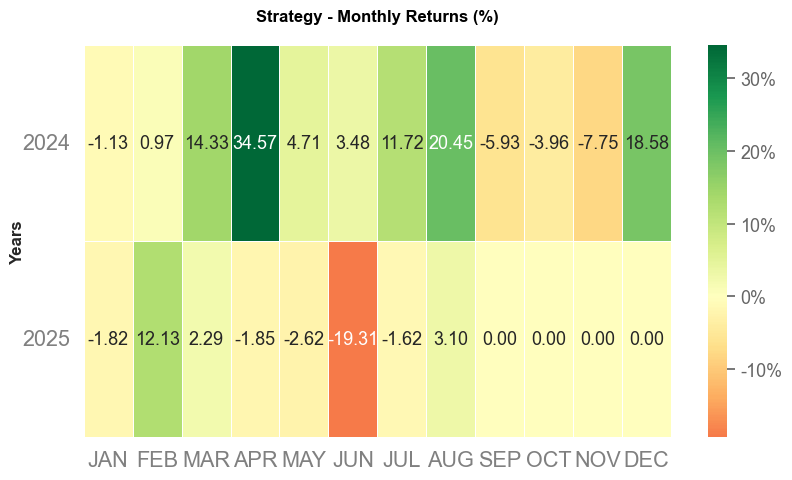

                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2025-08-06
Risk-Free Rate             0.0%
Time in Market             98.0%

Cumulative Return          94.98%
CAGR﹪                     33.53%

Sharpe                     1.43
Prob. Sharpe Ratio         97.34%
Smart Sharpe               1.37
Sortino                    2.94
Smart Sortino              2.82
Sortino/√2                 2.08
Smart Sortino/√2           2.0
Omega                      1.4

Max Drawdown               -27.86%
Longest DD Days            363
Volatility (ann.)          38.73%
Calmar                     1.2
Skew                       3.18
Kurtosis                   20.65

Expected Daily %           0.19%
Expected Monthly %         3.4%
Expected Yearly %          39.64%
Kelly Criterion            16.82%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.79%
Expected Shortfall (cVaR)  -3.79%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-08-09,2024-11-18,2025-08-06,363,-27.864903,-27.038056
2,2024-02-14,2024-02-16,2024-03-04,20,-4.038151,-3.924498
3,2024-01-03,2024-01-05,2024-02-01,30,-3.758102,-2.274500
4,2024-07-26,2024-07-29,2024-07-31,6,-3.719789,-1.815000
5,2024-05-03,2024-05-09,2024-05-31,29,-3.319925,-3.190000


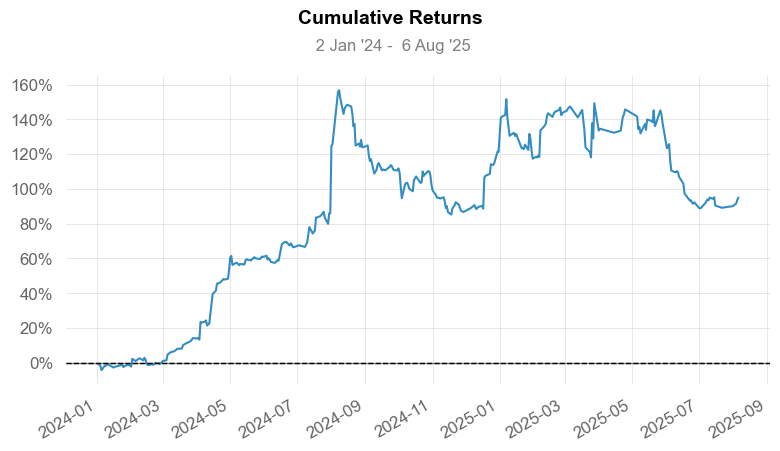

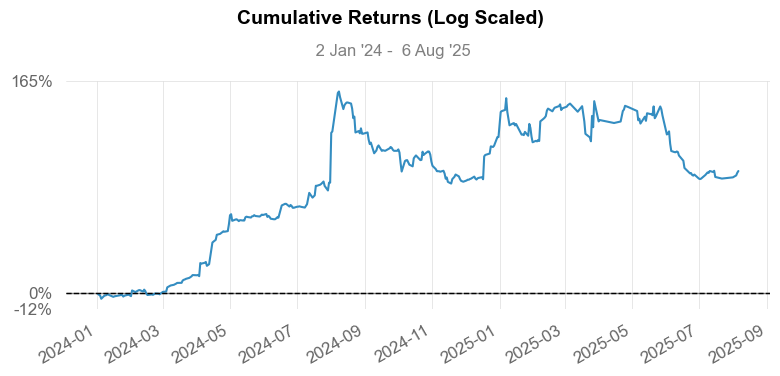

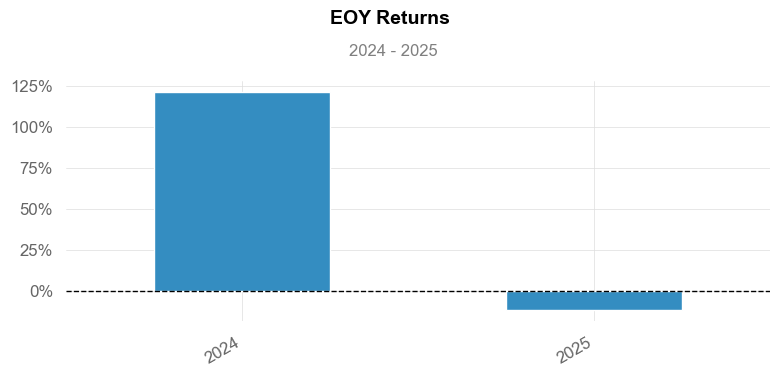

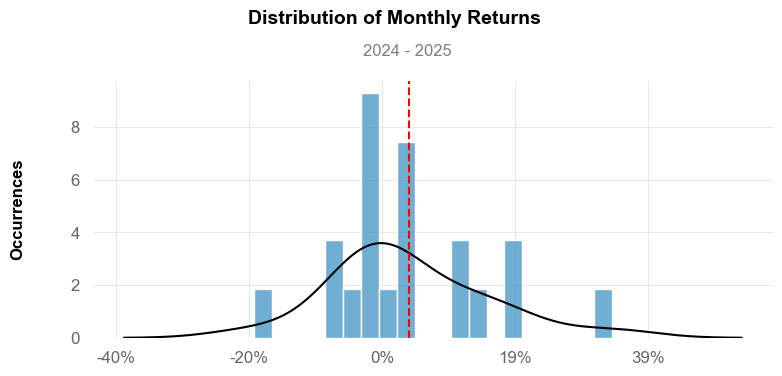

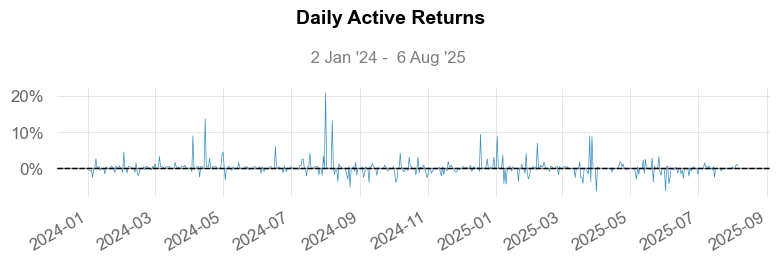

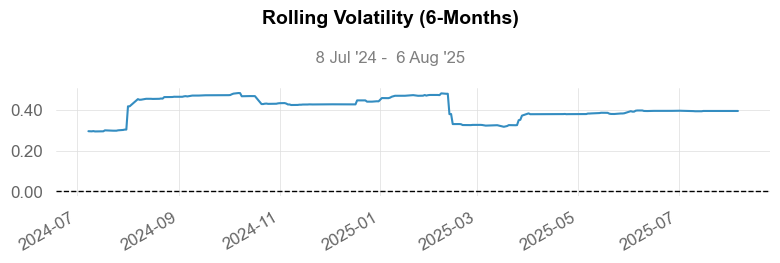

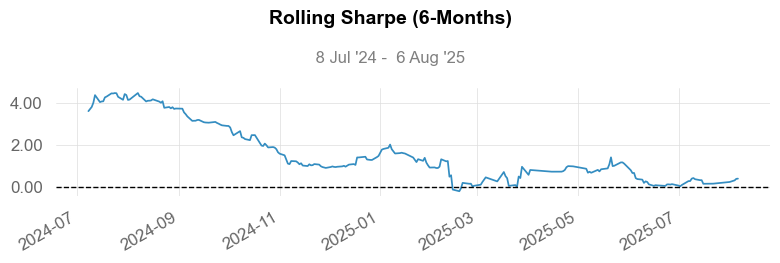

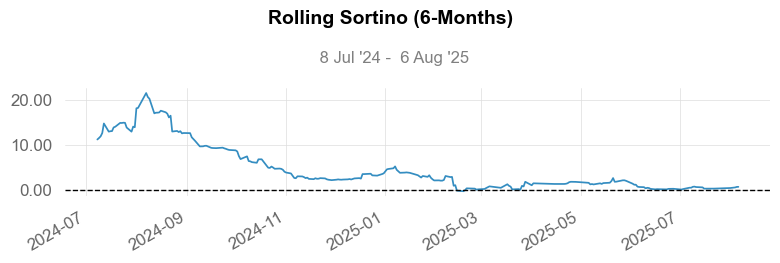

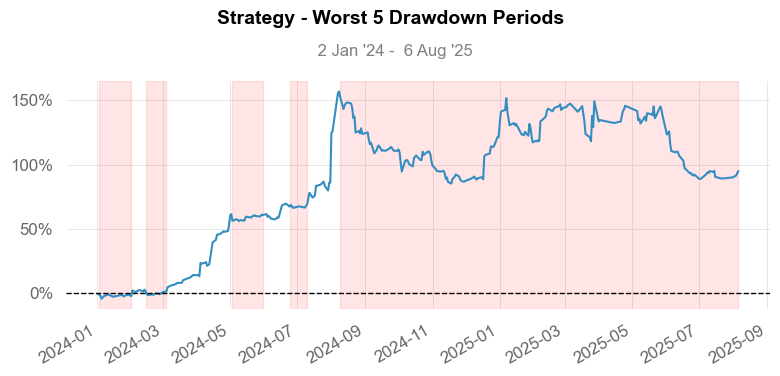

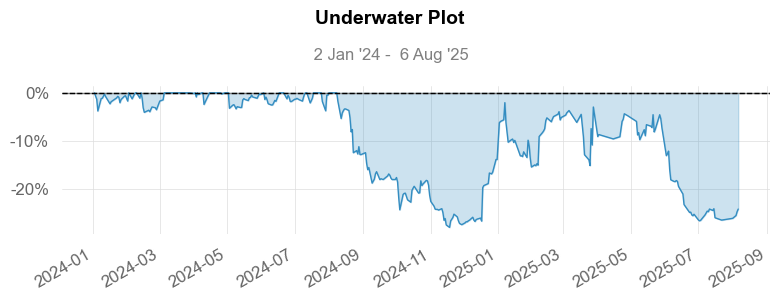

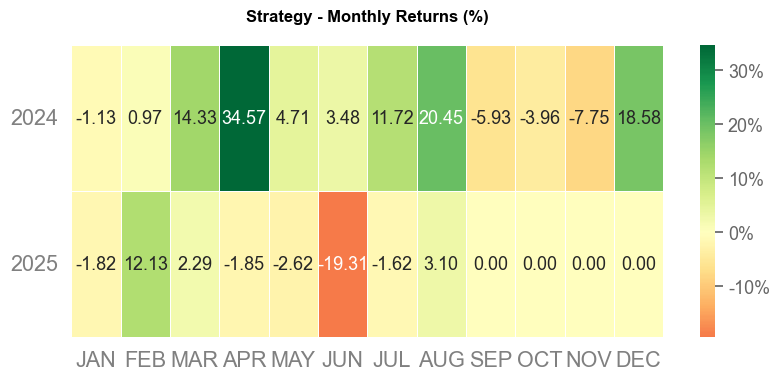

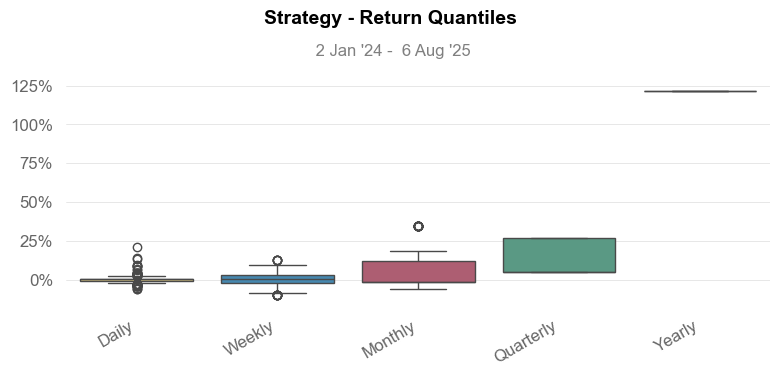

In [115]:
df_trades2.index = pd.to_datetime(df_trades2.index)
df_trades2["return"] = df_trades2["combined_pnl"]/50000
qs.plots.monthly_heatmap(df_trades2["return"])
qs.reports.full(df_trades2["return"])